In [ ]:
!pip install openpyxl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/GDSC2_fitted_dose_response_27Oct23 paper new.xlsx'

df = pd.read_excel(file_path)

df.head()

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
0,GDSC2,343,15946310,683667,PFSK-1,SIDM01132,MB,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-1.463887,0.930220,0.089052,0.433123
1,GDSC2,343,15946548,684052,A673,SIDM00848,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-4.869455,0.614970,0.111351,-1.421100
2,GDSC2,343,15946830,684057,ES5,SIDM00263,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-3.360586,0.791072,0.142855,-0.599569
3,GDSC2,343,15947087,684059,ES7,SIDM00269,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-5.044940,0.592660,0.135539,-1.516647
4,GDSC2,343,15947369,684062,EW-11,SIDM00203,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-3.741991,0.734047,0.128059,-0.807232


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns



# Select relevant numeric features for clustering
features_to_use = ['LN_IC50', 'AUC', 'Z_SCORE']


cell_lines = df['CELL_LINE_NAME'].unique()


for cell in cell_lines:
    print(f"\n🔬 Clustering drugs for Cell Line: {cell}")


    cell_df = df[df['CELL_LINE_NAME'] == cell].copy()

    cell_df = cell_df.dropna(subset=features_to_use)

    if len(cell_df) < 3:
        print("  Skipped (not enough data)")
        continue

    features = cell_df[features_to_use]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)

    cell_df['Cluster'] = clusters

    summary = cell_df[['DRUG_NAME', 'Cluster']].groupby('Cluster').agg(list)
    print(summary)

Streaming output truncated to the last 5000 lines.
1        [Camptothecin, Vinblastine, Docetaxel, Methotr...
2        [Cytarabine, Gefitinib, Navitoclax, Vorinostat...

🔬 Clustering drugs for Cell Line: DB
                                                 DRUG_NAME
Cluster                                                   
0        [Refametinib, Olaparib, Lenalidomide, Axitinib...
1        [Camptothecin, Vinblastine, Docetaxel, Methotr...
2        [Cisplatin, Cytarabine, Gefitinib, Nilotinib, ...

🔬 Clustering drugs for Cell Line: Daoy
                                                 DRUG_NAME
Cluster                                                   
0        [Cytarabine, Vorinostat, Temsirolimus, Olapari...
1        [Camptothecin, Vinblastine, Cisplatin, Docetax...
2        [Gefitinib, Navitoclax, Nilotinib, Refametinib...

🔬 Clustering drugs for Cell Line: D-283MED
                                                 DRUG_NAME
Cluster                                                   
0

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, jaccard_score
from scipy.spatial.distance import cdist, pdist
import numpy as np

def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    distances = cdist(X, X, 'euclidean')

    intra_dists = []
    inter_dists = []

    for i in unique_clusters:
        intra_cluster = np.where(labels == i)[0]
        if len(intra_cluster) > 1:
            intra = np.max(distances[np.ix_(intra_cluster, intra_cluster)])
            intra_dists.append(intra)

    for i in range(len(unique_clusters)):
        for j in range(i + 1, len(unique_clusters)):
            cluster_i = np.where(labels == unique_clusters[i])[0]
            cluster_j = np.where(labels == unique_clusters[j])[0]
            inter = np.min(distances[np.ix_(cluster_i, cluster_j)])
            inter_dists.append(inter)

    if len(intra_dists) == 0 or len(inter_dists) == 0:
        return np.nan
    return min(inter_dists) / max(intra_dists)

# Silhouette Score
sil_score = silhouette_score(scaled_features, clusters)

# Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, clusters)

# Dunn Index (custom)
dunn = dunn_index(scaled_features, clusters)

print(f"📊 Clustering Metrics for Cell Line: {cell}")
print(f"   • Silhouette Score:        {sil_score:.4f}")
print(f"   • Davies-Bouldin Index:    {db_index:.4f}")
print(f"   • Dunn Index:              {dunn:.4f}")


📊 Clustering Metrics for Cell Line: HCC202
   • Silhouette Score:        0.4943
   • Davies-Bouldin Index:    0.5022
   • Dunn Index:              0.3919


In [ ]:
# Choose a specific cell line, e.g., H1975
cell_line = 'NCI-H1975'

cell_df = df[df['CELL_LINE_NAME'] == cell_line].copy()

cell_df = cell_df.dropna(subset=['LN_IC50', 'AUC', 'Z_SCORE'])

top_drugs = cell_df.sort_values(by='LN_IC50').head(10)

top_drugs[['DRUG_NAME', 'LN_IC50', 'AUC', 'Z_SCORE']]

,DRUG_NAME,LN_IC50,AUC,Z_SCORE
200611,Sepantronium bromide,-6.332744,0.062259,-1.340218
153428,Romidepsin,-6.030686,0.725243,-0.789124
180716,Dactinomycin,-6.010544,0.245115,-0.776155
67284,Bortezomib,-5.920959,0.664558,-1.108263
1476,Vinblastine,-5.282105,0.555256,-0.822683
3838,Docetaxel,-5.090236,0.792041,-0.467504
25203,Staurosporine,-4.368655,0.229592,-1.137887
51997,Rapamycin,-3.417357,0.879940,-0.850242
149127,Dactinomycin,-3.278775,0.922213,-0.630328
187422,Osimertinib,-3.272124,0.521202,-3.856830


In [ ]:
# Filter the dataset for Cisplatin
cisplatin_df = df[df['DRUG_NAME'].str.lower() == 'cisplatin'].copy()

cisplatin_df = cisplatin_df.dropna(subset=['LN_IC50', 'AUC', 'Z_SCORE'])


cisplatin_sorted = cisplatin_df.sort_values(by='LN_IC50')

cisplatin_sorted[['CELL_LINE_NAME', 'LN_IC50', 'AUC', 'Z_SCORE']].head(10)

,CELL_LINE_NAME,LN_IC50,AUC,Z_SCORE
2263,EW-3,-1.730244,0.515862,-2.688692
1753,NCI-H209,-1.309713,0.570725,-2.460397
2197,SCC-3,-1.267597,0.579927,-2.437534
2268,EW-22,-0.788236,0.629935,-2.177302
2043,NAMALWA,-0.597402,0.665987,-2.073703
2054,NUGC-3,-0.541849,0.647338,-2.043545
2203,COR-L279,-0.488126,0.673042,-2.014380
2099,SK-CO-1,-0.471954,0.660879,-2.005601
2201,A3-KAW,-0.467949,0.685507,-2.003427
2041,MV-4-11,-0.288379,0.710626,-1.905943


In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import skfuzzy as fuzz
from sklearn.preprocessing import StandardScaler

# Select relevant numeric features for clustering
features_to_use = ['LN_IC50', 'AUC', 'Z_SCORE']
cell_lines = df['CELL_LINE_NAME'].unique()

for cell in cell_lines:
    print(f"\n🧪 Fuzzy Clustering drugs for Cell Line: {cell}")

    cell_df = df[df['CELL_LINE_NAME'] == cell].copy()
    cell_df = cell_df.dropna(subset=features_to_use)

    if len(cell_df) < 3:
        print("  Skipped (not enough data)")
        continue

    features = cell_df[features_to_use]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Transpose because skfuzzy expects features x samples
    scaled_features_T = scaled_features.T

    # Run FCM
    n_clusters = 3
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        scaled_features_T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None, seed=42
    )

    # u: membership matrix (clusters x samples)
    membership = u.T  # shape: (samples x clusters)

    # Assign cluster with highest membership
    cell_df['Cluster'] = np.argmax(membership, axis=1)

    # Add max membership value per sample (for confidence)
    cell_df['Max_Membership'] = np.max(membership, axis=1)

    # Group drugs by cluster
    summary = cell_df[['DRUG_NAME', 'Max_Membership']].groupby(cell_df['Cluster']).agg(list)
    print(summary)


Streaming output truncated to the last 5000 lines.
1        [Camptothecin, Vinblastine, Docetaxel, Refamet...   
2        [Cisplatin, Cytarabine, Navitoclax, Vorinostat...   

                                            Max_Membership  
Cluster                                                     
0        [0.6331927259252239, 0.9421311897433906, 0.787...  
1        [0.5067722537421627, 0.6925790718358619, 0.580...  
2        [0.7583232834964306, 0.8089066659144812, 0.820...  

🧪 Fuzzy Clustering drugs for Cell Line: 769-P
                                                 DRUG_NAME  \
Cluster                                                      
0        [Veliparib, Lenalidomide, GW441756, SB216763, ...   
1        [Cisplatin, Cytarabine, Gefitinib, Nilotinib, ...   
2        [Camptothecin, Vinblastine, Docetaxel, Methotr...   

                                            Max_Membership  
Cluster                                                     
0        [0.5496633418895533, 0.9282338

In [ ]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from sklearn.preprocessing import StandardScaler

features_to_use = ['LN_IC50', 'AUC', 'Z_SCORE']
cell_lines = df['CELL_LINE_NAME'].unique()

for cell in cell_lines:
    print(f"\n🧪 Fuzzy Clustering drugs for Cell Line: {cell}")

    cell_df = df[df['CELL_LINE_NAME'] == cell].copy()
    cell_df = cell_df.dropna(subset=features_to_use)

    if len(cell_df) < 3:
        print("  Skipped (not enough data)")
        continue

    features = cell_df[features_to_use]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    scaled_features_T = scaled_features.T


    n_clusters = 3
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        scaled_features_T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None, seed=42
    )

    membership = u.T

    # Assign each drug to the cluster with the highest membership
    cell_df['Cluster'] = np.argmax(membership, axis=1)
    cell_df['Max_Membership'] = np.max(membership, axis=1)


    membership_df = pd.DataFrame(membership, columns=[f'Cluster_{i}_Score' for i in range(n_clusters)])
    membership_df['DRUG_NAME'] = cell_df['DRUG_NAME'].values
    membership_df['Assigned_Cluster'] = cell_df['Cluster'].values
    membership_df['Max_Membership'] = cell_df['Max_Membership'].values


    cols = ['DRUG_NAME', 'Assigned_Cluster', 'Max_Membership'] + [f'Cluster_{i}_Score' for i in range(n_clusters)]
    membership_df = membership_df[cols]


    print(f"\n📋 Drug Clustering Summary for Cell Line: {cell}")
    print(membership_df.to_string(index=False))


Streaming output truncated to the last 5000 lines.
             GSK1904529A                 0        0.949538         0.949538         0.038965         0.011497
              PRIMA-1MET                 1        0.923443         0.046774         0.923443         0.029783
              Serdemetan                 0        0.971100         0.971100         0.024155         0.004745
               Erlotinib                 1        0.848670         0.071199         0.848670         0.080131
               Rucaparib                 0        0.958020         0.958020         0.035394         0.006586
               Niraparib                 0        0.520797         0.520797         0.437222         0.041981
                 MK-1775                 1        0.461953         0.331308         0.461953         0.206739
              Dinaciclib                 2        0.850739         0.050163         0.099098         0.850739
             Gemcitabine                 2        0.951439         0.

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import numpy as np

# Function to compute Dunn Index
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    distances = cdist(X, X, 'euclidean')

    intra_dists = []
    inter_dists = []

    for i in unique_clusters:
        intra_cluster = np.where(labels == i)[0]
        if len(intra_cluster) > 1:
            intra = np.max(distances[np.ix_(intra_cluster, intra_cluster)])
            intra_dists.append(intra)

    for i in range(len(unique_clusters)):
        for j in range(i + 1, len(unique_clusters)):
            cluster_i = np.where(labels == unique_clusters[i])[0]
            cluster_j = np.where(labels == unique_clusters[j])[0]
            inter = np.min(distances[np.ix_(cluster_i, cluster_j)])
            inter_dists.append(inter)

    if len(intra_dists) == 0 or len(inter_dists) == 0:
        return np.nan
    return min(inter_dists) / max(intra_dists)


In [ ]:
# Use scaled features for metric calculations
labels = cell_df['Cluster'].values

# Silhouette Score
sil_score = silhouette_score(scaled_features, labels)

# Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, labels)

# Dunn Index
dunn = dunn_index(scaled_features, labels)


print(f"\n📊 Clustering Evaluation Metrics for Cell Line: {cell}")
print(f"   • Silhouette Score:        {sil_score:.4f}")
print(f"   • Davies-Bouldin Index:    {db_index:.4f}")
print(f"   • Dunn Index:              {dunn:.4f}")
print(f"   • Fuzzy Partition Coeff.:  {fpc:.4f}")


📊 Clustering Evaluation Metrics for Cell Line: HCC202
   • Silhouette Score:        0.5648
   • Davies-Bouldin Index:    0.5633
   • Dunn Index:              0.4101
   • Fuzzy Partition Coeff.:  0.8284


/tmp/ipython-input-15-1353704084.py:97: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


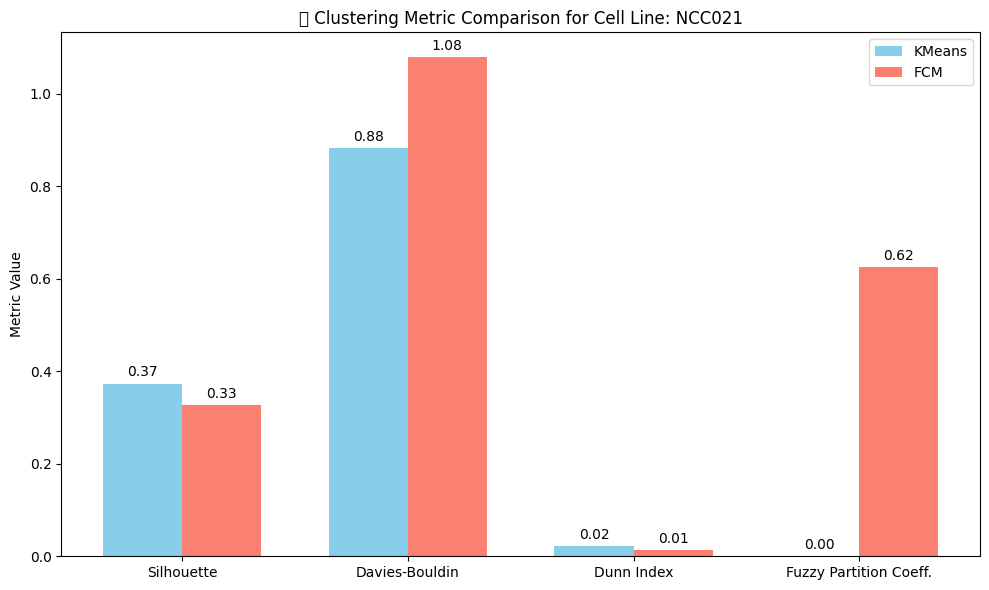

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import skfuzzy as fuzz
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Dunn Index Function
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    distances = cdist(X, X, 'euclidean')

    intra_dists = []
    inter_dists = []

    for i in unique_clusters:
        intra_cluster = np.where(labels == i)[0]
        if len(intra_cluster) > 1:
            intra = np.max(distances[np.ix_(intra_cluster, intra_cluster)])
            intra_dists.append(intra)

    for i in range(len(unique_clusters)):
        for j in range(i + 1, len(unique_clusters)):
            cluster_i = np.where(labels == unique_clusters[i])[0]
            cluster_j = np.where(labels == unique_clusters[j])[0]
            inter = np.min(distances[np.ix_(cluster_i, cluster_j)])
            inter_dists.append(inter)

    if len(intra_dists) == 0 or len(inter_dists) == 0:
        return np.nan
    return min(inter_dists) / max(intra_dists)

# -------------------------
# Choose the cell line
cell_line = "NCC021"  # 🔁 Replace with desired cell line
features_to_use = ['LN_IC50', 'AUC', 'Z_SCORE']

# Filter and preprocess
cell_df = df[df['CELL_LINE_NAME'] == cell_line].dropna(subset=features_to_use).copy()

if len(cell_df) < 3:
    print(f"❌ Not enough data for {cell_line}")
else:
    features = cell_df[features_to_use]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    X = scaled_features

    # --- KMeans ---
    kmeans = KMeans(n_clusters=3, random_state=42)
    k_labels = kmeans.fit_predict(X)

    k_sil = silhouette_score(X, k_labels)
    k_db = davies_bouldin_score(X, k_labels)
    k_dunn = dunn_index(X, k_labels)

    # --- FCM ---
    X_T = X.T
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_T, c=3, m=2, error=0.005, maxiter=1000, init=None, seed=42
    )

    f_labels = np.argmax(u, axis=0)
    f_sil = silhouette_score(X, f_labels)
    f_db = davies_bouldin_score(X, f_labels)
    f_dunn = dunn_index(X, f_labels)

    # --- Plotting ---
    metrics = ['Silhouette', 'Davies-Bouldin', 'Dunn Index', 'Fuzzy Partition Coeff.']
    k_values = [k_sil, k_db, k_dunn, 0]
    f_values = [f_sil, f_db, f_dunn, fpc]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, k_values, width, label='KMeans', color='skyblue')
    bars2 = ax.bar(x + width/2, f_values, width, label='FCM', color='salmon')

    ax.set_ylabel('Metric Value')
    ax.set_title(f'🔬 Clustering Metric Comparison for Cell Line: {cell_line}')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Add value labels on bars
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


In [ ]:
print(drug_df.columns)  # See available columns
print(drug_df.head())   # See actual data


Index(['DATASET', 'NLME_RESULT_ID', 'NLME_CURVE_ID', 'COSMIC_ID',
       'CELL_LINE_NAME', 'SANGER_MODEL_ID', 'TCGA_DESC', 'DRUG_ID',
       'DRUG_NAME', 'PUTATIVE_TARGET', 'PATHWAY_NAME', 'COMPANY_ID',
       'WEBRELEASE', 'MIN_CONC', 'MAX_CONC', 'LN_IC50', 'AUC', 'RMSE',
       'Z_SCORE'],
      dtype='object')
  DATASET  NLME_RESULT_ID  NLME_CURVE_ID  COSMIC_ID CELL_LINE_NAME  \
0   GDSC2             343       15946310     683667         PFSK-1   
1   GDSC2             343       15946548     684052           A673   
2   GDSC2             343       15946830     684057            ES5   
3   GDSC2             343       15947087     684059            ES7   
4   GDSC2             343       15947369     684062          EW-11   

  SANGER_MODEL_ID     TCGA_DESC  DRUG_ID     DRUG_NAME PUTATIVE_TARGET  \
0       SIDM01132            MB     1003  Camptothecin            TOP1   
1       SIDM00848  UNCLASSIFIED     1003  Camptothecin            TOP1   
2       SIDM00263  UNCLASSIFIED     1003  

In [ ]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from sklearn.preprocessing import StandardScaler

# Assuming df is already loaded and cleaned
features_to_use = ['LN_IC50', 'AUC', 'Z_SCORE']
cell_lines = df['CELL_LINE_NAME'].unique()

all_clustered_data = []  # <- 🧠 store all cell_df here

for cell in cell_lines:
    print(f"\n🧪 Fuzzy Clustering drugs for Cell Line: {cell}")

    cell_df = df[df['CELL_LINE_NAME'] == cell].copy()
    cell_df = cell_df.dropna(subset=features_to_use)

    if len(cell_df) < 3:
        print("  Skipped (not enough data)")
        continue

    features = cell_df[features_to_use]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    scaled_features_T = scaled_features.T

    n_clusters = 3
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        scaled_features_T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None, seed=42
    )

    membership = u.T
    cell_df['Cluster'] = np.argmax(membership, axis=1)
    cell_df['Max_Membership'] = np.max(membership, axis=1)

    all_clustered_data.append(cell_df)  # ✅ collect this cell_df

    membership_df = pd.DataFrame(membership, columns=[f'Cluster_{i}_Score' for i in range(n_clusters)])
    membership_df['DRUG_NAME'] = cell_df['DRUG_NAME'].values
    membership_df['Assigned_Cluster'] = cell_df['Cluster'].values
    membership_df['Max_Membership'] = cell_df['Max_Membership'].values

    cols = ['DRUG_NAME', 'Assigned_Cluster', 'Max_Membership'] + [f'Cluster_{i}_Score' for i in range(n_clusters)]
    membership_df = membership_df[cols]

    print(f"\n📋 Drug Clustering Summary for Cell Line: {cell}")
    print(membership_df.to_string(index=False))

# ✅ After loop ends, combine all
clustered_df = pd.concat(all_clustered_data, ignore_index=True)

# Now this will work:
print("\n✅ Now you can access clustered_df['Cluster'] without error.")


Streaming output truncated to the last 5000 lines.
              Serdemetan                 0        0.971100         0.971100         0.024155         0.004745
               Erlotinib                 1        0.848670         0.071199         0.848670         0.080131
               Rucaparib                 0        0.958020         0.958020         0.035394         0.006586
               Niraparib                 0        0.520797         0.520797         0.437222         0.041981
                 MK-1775                 1        0.461953         0.331308         0.461953         0.206739
              Dinaciclib                 2        0.850739         0.050163         0.099098         0.850739
             Gemcitabine                 2        0.951439         0.014648         0.033912         0.951439
              Bortezomib                 2        0.524039         0.165433         0.310528         0.524039
               Tamoxifen                 0        0.639324         0.

In [ ]:
print("Columns in clustered_df:", clustered_df.columns)

# Check sample row
print(clustered_df.head())

# Try simple access
print(clustered_df['Cluster'].value_counts())


Columns in clustered_df: Index(['DATASET', 'NLME_RESULT_ID', 'NLME_CURVE_ID', 'COSMIC_ID',
       'CELL_LINE_NAME', 'SANGER_MODEL_ID', 'TCGA_DESC', 'DRUG_ID',
       'DRUG_NAME', 'PUTATIVE_TARGET', 'PATHWAY_NAME', 'COMPANY_ID',
       'WEBRELEASE', 'MIN_CONC', 'MAX_CONC', 'LN_IC50', 'AUC', 'RMSE',
       'Z_SCORE', 'Cluster', 'Max_Membership'],
      dtype='object')
  DATASET  NLME_RESULT_ID  NLME_CURVE_ID  COSMIC_ID CELL_LINE_NAME  \
0   GDSC2             343       15946310     683667         PFSK-1   
1   GDSC2             343       15946311     683667         PFSK-1   
2   GDSC2             343       15946312     683667         PFSK-1   
3   GDSC2             343       15946313     683667         PFSK-1   
4   GDSC2             343       15946314     683667         PFSK-1   

  SANGER_MODEL_ID TCGA_DESC  DRUG_ID     DRUG_NAME           PUTATIVE_TARGET  \
0       SIDM01132        MB     1003  Camptothecin                      TOP1   
1       SIDM01132        MB     1004   Vinblastine